# Project submission

## 1. Generating images
We need some dataset to train GAN on existing image to get some distribution. Why not to take MoMA collection?

https://github.com/MuseumofModernArt/collection

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torchvision.datasets import *
import seaborn as sns
import pandas as pd
from IPython.display import clear_output

### Dataset is, khm, interesting


In [6]:
# CSV - via pandas, then torch.Tensor(df.values)
! wget -nc https://github.com/MuseumofModernArt/collection/raw/master/Artworks.csv


df = pd.read_csv('Artworks.csv', sep=',')
df = df[['Title', 'Artist', 'Date', 'Classification', 'URL', 'ThumbnailURL']].dropna() 
# Select only 1 type of images
df = df[df['Classification']=='Architecture']
df.info()

File ‘Artworks.csv’ already there; not retrieving.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2217 entries, 0 to 135898
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Title           2217 non-null   object
 1   Artist          2217 non-null   object
 2   Date            2217 non-null   object
 3   Classification  2217 non-null   object
 4   URL             2217 non-null   object
 5   ThumbnailURL    2217 non-null   object
dtypes: object(6)
memory usage: 121.2+ KB


In [7]:
import requests
import cv2


try:
  arr = np.load("arr.npy", allow_pickle=True)
except (IOError, ValueError) as e:
  print(e)
  converted_stuff = list()
  for i in df.index.tolist():
    clear_output(wait=True)
    print(f'{i} / {max(df.index)}')
    r = requests.get(df['ThumbnailURL'].loc[i], stream=True)
    if r.status_code == 200:
      with open('tmp.jpg', 'wb') as f:
        for chunk in r:
          f.write(chunk)
    converted_stuff.append(cv2.imread('tmp.jpg', cv2.IMREAD_COLOR))
  print("Dataset done")
  arr = np.asarray(converted_stuff)
  np.save("arr.npy", arr)

135898 / 135898
Dataset done


OK, we got some data. Now, we'd like to convert images to PyTorch Tensor.

In [10]:
import random
torch.manual_seed(225)
random.seed(225)


# Resize all arrays to (128, 128)
dataset = []
for i in range(arr.shape[0]):
  dataset.append(cv2.resize(arr[i], (64, 64)))
dataset = np.asarray(dataset)
print('Now we have {} images, each of size {}*{} with {} channels'.format(*dataset.shape), end=', converted to the array of shape ')

dataset = dataset.reshape((dataset.shape[0], dataset.shape[1]*dataset.shape[2]*dataset.shape[3]))
print(dataset.shape)

train_data = torch.Tensor(dataset)
print("Shape of respective Tensor:", train_data.shape)

Now we have 2217 images, each of size 64*64 with 3 channels, converted to the array of shape (2217, 12288)
Shape of respective Tensor: torch.Size([2217, 12288])


## Defining the models
* Since we do not really care, why cannot we generate the images of constant size? If needed, we can resize it later.
* Then, we will encode images of size (64,64,3) to (100,)-vector
* And on back, we'll do the vice-versa

In [12]:
class Encoder(nn.Module):
    def __init__(self, dimensions=(64*64*3, 64*64, 32*32, 800, 100)):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(in_features=dimensions[0], out_features=dimensions[1])
        self.fc2 = nn.Linear(in_features=dimensions[1], out_features=dimensions[2])
        self.fc3 = nn.Linear(in_features=dimensions[2], out_features=dimensions[3])
        self.fc4 = nn.Linear(in_features=dimensions[3], out_features=dimensions[4])

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.sigmoid(self.fc4(x))
        return x

# https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
nc, nz, ngf = 3, 100, 64
class Generator(nn.Module):
    def __init__(self,):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)


device = torch.device("cpu")
device

device(type='cpu')

In [13]:
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=64, shuffle=False, num_workers=2)

## Training GAN-like

* Both encoder and generator are trained together in order to use shared distribution
* In the below cells, we will use only generator


In [14]:
try:
  encoder = torch.load("encoder_model")
  generator = torch.load("generator_model")
except:
  encoder = Encoder().to(device)
  generator = Generator().to(device)

  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(encoder.parameters(), lr=0.001)
  optimizerG = torch.optim.Adam(encoder.parameters(), lr=0.001)
  n_epochs = 5

  for epoch in range(n_epochs):
    train_loss = 0.0
    for images in train_loader:
      # Training encoder
      encoder.zero_grad()
      images = images.view(images.size(0), -1)
      b_size = images.size(0)
      label = torch.full((b_size,), 1, dtype=torch.float, device=device)
      outputs = encoder(images).view(-1)
      loss = criterion(outputs.sum(), images)
      loss.backward()
      train_loss += loss.item()*images.size(0)
      optimizer.step()

      # Training generator: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
      generator.zero_grad()
      noise = torch.randn(b_size, nz, 1, 1, device=device)
      fake = generator(noise)
      fake = fake.view(fake.size(0), -1)
      output = encoder(fake.detach()).view(-1)
      errD_fake = criterion(output.sum(), images)
      errD_fake.backward()
      optimizer.step()

      generator.zero_grad()
      output = encoder(fake).view(-1)
      errG = criterion(output.sum(), images)
      errG.backward()
      D_G_z2 = output.mean().item()
      optimizerG.step()
    
    print(f'Epoch: {epoch}, encoder train loss: {train_loss / len(train_loader):.6f}, generator train loss: {D_G_z2}')    
  torch.save(encoder, "encoder_model")
  torch.save(generator, "generator_model")


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([64, 12288])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([41, 12288])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0, encoder train loss: 21222143.493750, generator train loss: 0.0
Epoch: 1, encoder train loss: 2259301.043750, generator train loss: 0.0
Epoch: 2, encoder train loss: 2259301.043750, generator train loss: 0.0
Epoch: 3, encoder train loss: 2259301.043750, generator train loss: 0.0
Epoch: 4, encoder train loss: 2259301.043750, generator train loss: 0.0


## Examples of image generation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


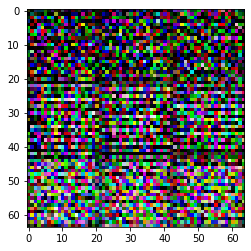

In [18]:
# Use some noise
noise = torch.randn(1, nz, 1, 1, device=device)
image = generator(noise).detach().numpy()[0]
image = image.reshape((image.shape[1], image.shape[2], image.shape[0]))
plt.imshow(image);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


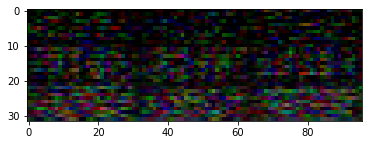

In [32]:
# Use constant value
noise = torch.full((1,100,1,1), .00000004, dtype=torch.float, device=device)
image = generator(noise).detach().numpy()[0]
image = image.reshape((image.shape[1], image.shape[2], image.shape[0]))
plt.imshow(cv2.resize(image, (96, 32)));

## 2. Adapting existing images
I have decided just to add the text about input image.



In [43]:
from random import randint as rint
import cv2


class ImageTextMixer:
  def __init__(self):
    pass

  def mix(self, image: np.ndarray, text: str) -> np.ndarray:
    for symbol in text:
      pos = (rint(0, image.shape[1] - 1), rint(0, image.shape[0] - 1))
      color0 = rint(0, 255)
      color = (color0, color0, color0)
      fontScale = 1
      font = cv2.FONT_HERSHEY_SIMPLEX 
      image = cv2.putText(image, symbol, pos, font, fontScale, color, 1, cv2.LINE_AA)
    return image


mixer = ImageTextMixer()

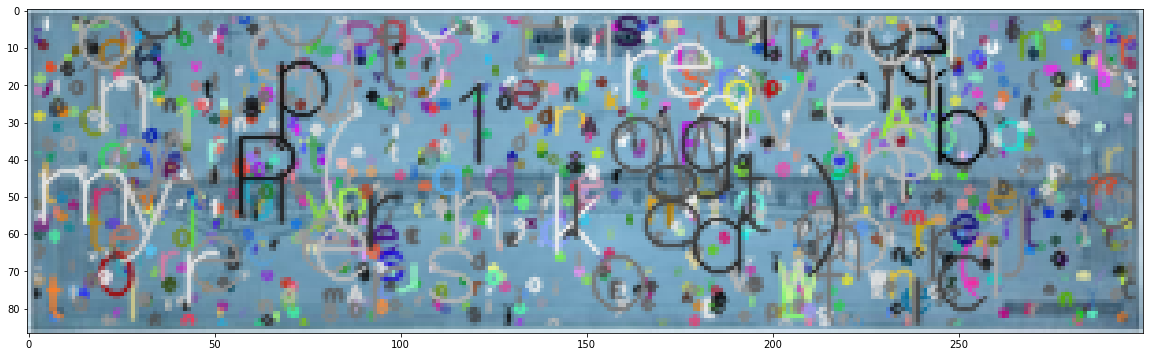

In [44]:
plt.figure(figsize=(20,10))
plt.imshow(mixer.mix(arr[0], ''.join(df.loc[0].tolist()[:3])))

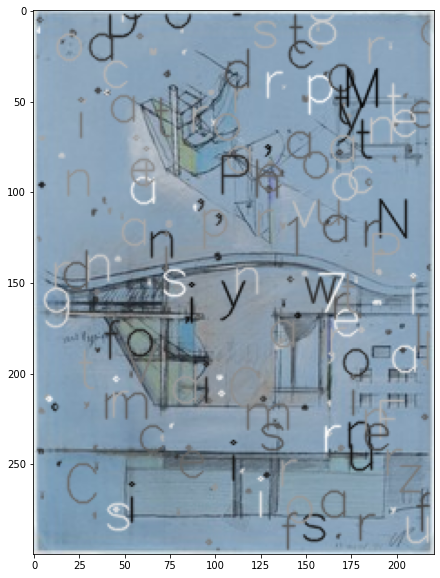

In [45]:
plt.figure(figsize=(20,10))
plt.imshow(mixer.mix(arr[1], ''.join(df.loc[1].tolist()[:3])))